In [2]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import h5py
import pandas as pd
from pn_models import PointNetMLPJoint
from benchmarks import VanillaDeepONet, SpectralDeepONet, DenseNoFFT
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {device}')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

Using device: cuda


In [3]:
# Set up directory paths
current_dir = os.getcwd()
repo_dir = os.path.dirname(current_dir)

# Data paths
L_bracket_data_path = Path(repo_dir, 'L_Bracket', 'L_bracket_stress.h5')

# Model directories
model_dirs = {
    'PointNetMLPJoint20': Path(repo_dir, 'PointNetMLPJoint', 'Trained_models', 'L-_20p_pnmlp_f1d3e366.pt'),
    'PointNetMLPJoint40': Path(repo_dir, 'PointNetMLPJoint', 'Trained_models', 'L-_40p_pnmlp_f1d3e366.pt'),
    'PointNetMLPJoint60': Path(repo_dir, 'PointNetMLPJoint', 'Trained_models', 'L-_60p_pnmlp_f1d3e366.pt'),
    'PointNetMLPJoint80': Path(repo_dir, 'PointNetMLPJoint', 'Trained_models', 'L-_80p_pnmlp_f1d3e366.pt'),
    'PointNetMLPJoint100': Path(repo_dir, 'PointNetMLPJoint', 'Trained_models', 'L-_100p_pnmlp_f1d3e366.pt'),
    'VanillaDeepONet20': Path(repo_dir, 'VanillaDeepONet', 'Trained_models', 'L-_20p_pnmlp_0f778df7.pt'),
    'VanillaDeepONet40': Path(repo_dir, 'VanillaDeepONet', 'Trained_models', 'L-_40p_pnmlp_0f778df7.pt'),
    'VanillaDeepONet60': Path(repo_dir, 'VanillaDeepONet', 'Trained_models', 'L-_60p_pnmlp_0f778df7.pt'),
    'VanillaDeepONet80': Path(repo_dir, 'VanillaDeepONet', 'Trained_models', 'L-_80p_pnmlp_0f778df7.pt'),
    'VanillaDeepONet100': Path(repo_dir, 'VanillaDeepONet', 'Trained_models', 'L-_100p_pnmlp_0f778df7.pt'),
}


print('Data paths configured:')
print(f'  L_bracket data: {L_bracket_data_path.exists()}')
for model_name, model_path in model_dirs.items():
    print(f'  {model_name} model: {model_path.exists()}')


Data paths configured:
  L_bracket data: True
  PointNetMLPJoint20 model: True
  PointNetMLPJoint40 model: True
  PointNetMLPJoint60 model: True
  PointNetMLPJoint80 model: True
  PointNetMLPJoint100 model: True
  VanillaDeepONet20 model: True
  VanillaDeepONet40 model: True
  VanillaDeepONet60 model: True
  VanillaDeepONet80 model: True
  VanillaDeepONet100 model: True


## Helper Functions

In [4]:
def load_h5_data(path):
    """Load all samples from HDF5 file."""
    samples = []
    with h5py.File(path, 'r') as hf:
        keys = sorted(hf.keys(), key=lambda x: int(x.split('_')[1]))
        for key in keys:
            group = hf[key]
            sample = {
                'points': group['points'][:],  # (N, 2)
                'stress': group['stress'][:],  # (N, 1)
            }
            # Stack for tensor conversion
            coord_stress = np.hstack((sample['points'], sample['stress']))  # (N, 3)
            samples.append(torch.from_numpy(coord_stress).float())
    return samples

def get_validation_split(samples, test_size=0.2, random_state=42):
    """Split data into train and validation sets (matching training script)."""
    n_samples = len(samples)
    idxs = list(range(n_samples))
    train_idx, val_idx = train_test_split(idxs, test_size=test_size, random_state=random_state)
    val_samples = [samples[i] for i in val_idx]
    return val_samples, val_idx

print('Data loading functions defined')

Data loading functions defined


In [5]:
# Import the helper function for loading models
from load_models_helper import load_model_with_checkpoint

def load_model_and_checkpoint(model_path, model_type):
    """Wrapper around helper function for loading models."""
    return load_model_with_checkpoint(model_path, model_type, device=device)

print('Model loading function defined')

Model loading function defined


In [13]:
def evaluate_model(model, val_samples, norm_params):
    """Evaluate model on validation samples."""
    model.eval()
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for sample in val_samples:
            sample = sample.to(device)
            points = sample[:, :2]  # (N, 2)
            stress = sample[:, 2:3]  # (N, 1)
            
            # Normalize inputs
            points_norm = (points - norm_params['coord_center']) / norm_params['coord_half_range']
            stress_norm = (stress - norm_params['stress_mean']) / norm_params['stress_std']
            
            # Add batch dimension
            geom_points = points_norm.unsqueeze(0)  # (1, N, 2)
            query_points = points_norm.unsqueeze(0)  # (1, N, 2)
            
            # Predict
            pred_norm = model(geom_points, query_points)  # (1, N, 1)
            
            # Denormalize predictions
            pred = pred_norm * norm_params['stress_std'] + norm_params['stress_mean']
            
            all_preds.append(pred.squeeze().cpu().numpy())
            all_targets.append(stress.squeeze().cpu().numpy())
    
    # Concatenate all predictions and targets
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    # Calculate metrics
    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_preds)
    mae = np.mean(np.abs(all_targets - all_preds))
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

print('Evaluation function defined')

Evaluation function defined


In [14]:
# Load L_bracket data
print('Loading L_bracket dataset...')
L_bracket_samples = load_h5_data(L_bracket_data_path)
L_bracket_val_samples, L_bracket_val_idx = get_validation_split(L_bracket_samples)
print(f'Total samples: {len(L_bracket_samples)}')
print(f'Validation samples: {len(L_bracket_val_samples)}')

Loading L_bracket dataset...
Total samples: 5000
Validation samples: 1000


In [17]:
# Evaluate all L_bracket models
print('Evaluating L_bracket models...\n')
L_bracket_results = {}

for model_name, model_path in model_dirs.items():
    print(f'Evaluating {model_name}...')
    try:
        if 'PointNetMLPJoint' in model_name:
            model, norm_params, ckpt = load_model_and_checkpoint(model_path, 'PointNetMLPJoint')
        else:
            model, norm_params, ckpt = load_model_and_checkpoint(model_path, 'VanillaDeepONet')
        metrics = evaluate_model(model, L_bracket_val_samples, norm_params)
        metrics['Best_Val_Loss'] = ckpt.get('best_val_loss', None)
        L_bracket_results[model_name] = metrics
        print(f'  MSE: {metrics["MSE"]:.4f}, R²: {metrics["R2"]:.4f}\n')
    except Exception as e:
        print(f'  Error: {e}\n')
        L_bracket_results[model_name] = {'Error': str(e)}

print('L_bracket evaluation complete!')

Evaluating L_bracket models...

Evaluating PointNetMLPJoint20...
  MSE: 84.7411, R²: 0.9921

Evaluating PointNetMLPJoint40...
  MSE: 31.7025, R²: 0.9970

Evaluating PointNetMLPJoint60...
  MSE: 26.7915, R²: 0.9975

Evaluating PointNetMLPJoint80...
  MSE: 23.5328, R²: 0.9978

Evaluating PointNetMLPJoint100...
  MSE: 23.0311, R²: 0.9978

Evaluating VanillaDeepONet20...
  MSE: 566.7486, R²: 0.9470

Evaluating VanillaDeepONet40...
  MSE: 381.0496, R²: 0.9644

Evaluating VanillaDeepONet60...
  MSE: 310.5772, R²: 0.9710

Evaluating VanillaDeepONet80...
  MSE: 265.8810, R²: 0.9751

Evaluating VanillaDeepONet100...
  MSE: 245.8425, R²: 0.9770

L_bracket evaluation complete!


In [18]:
# Create comparison table for L_bracket
L_bracket_df = pd.DataFrame(L_bracket_results).T
L_bracket_df = L_bracket_df.round(4)
print('\n=== L_bracket Model Comparison ===')
print(L_bracket_df.to_string())
print(f'\nBest Model (lowest MSE): {L_bracket_df["MSE"].idxmin()}')
print(f'Best Model (highest R²): {L_bracket_df["R2"].idxmax()}')


=== L_bracket Model Comparison ===
                          MSE     RMSE      MAE      R2  Best_Val_Loss
PointNetMLPJoint20    84.7411   9.2055   5.4392  0.9921         0.0082
PointNetMLPJoint40    31.7025   5.6305   3.6646  0.9970         0.0029
PointNetMLPJoint60    26.7915   5.1761   3.2071  0.9975         0.0024
PointNetMLPJoint80    23.5328   4.8511   3.0185  0.9978         0.0021
PointNetMLPJoint100   23.0311   4.7991   2.9603  0.9978         0.0021
VanillaDeepONet20    566.7486  23.8065  15.1571  0.9470         0.0544
VanillaDeepONet40    381.0496  19.5205  12.8380  0.9644         0.0347
VanillaDeepONet60    310.5772  17.6232  11.8497  0.9710         0.0278
VanillaDeepONet80    265.8810  16.3059  11.0525  0.9751         0.0237
VanillaDeepONet100   245.8425  15.6794  10.6782  0.9770         0.0223

Best Model (lowest MSE): PointNetMLPJoint100
Best Model (highest R²): PointNetMLPJoint80


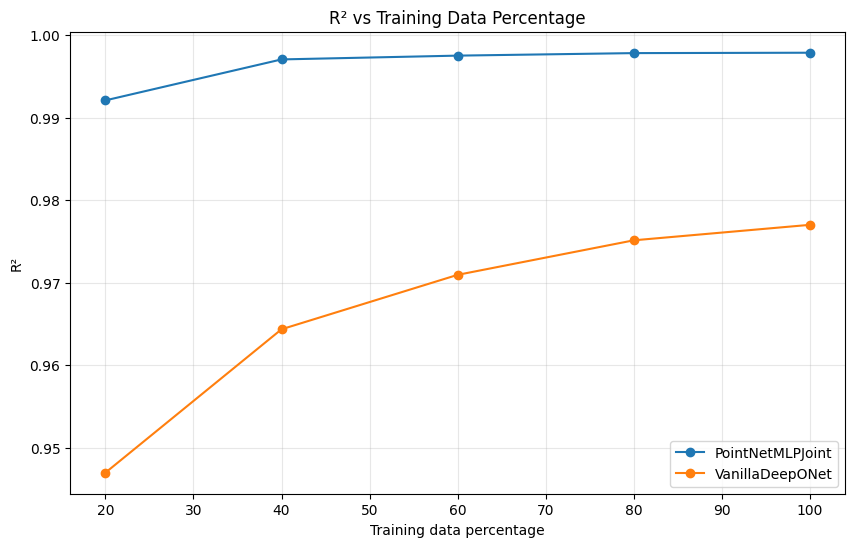

In [20]:
#plot R2 against percentage of training data for each model
plt.figure(figsize=(10, 6))
percentages = [20, 40, 60, 80, 100]

# Build model families safely by removing trailing digits (e.g., 20/40/60/80/100)
model_families = sorted({name.rstrip('0123456789') for name in model_dirs.keys()})

for family in model_families:
    r2_values = [L_bracket_results[f'{family}{p}']['R2'] for p in percentages]
    plt.plot(percentages, r2_values, marker='o', label=family)

plt.xlabel('Training data percentage')
plt.ylabel('R²')
plt.title('R² vs Training Data Percentage')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

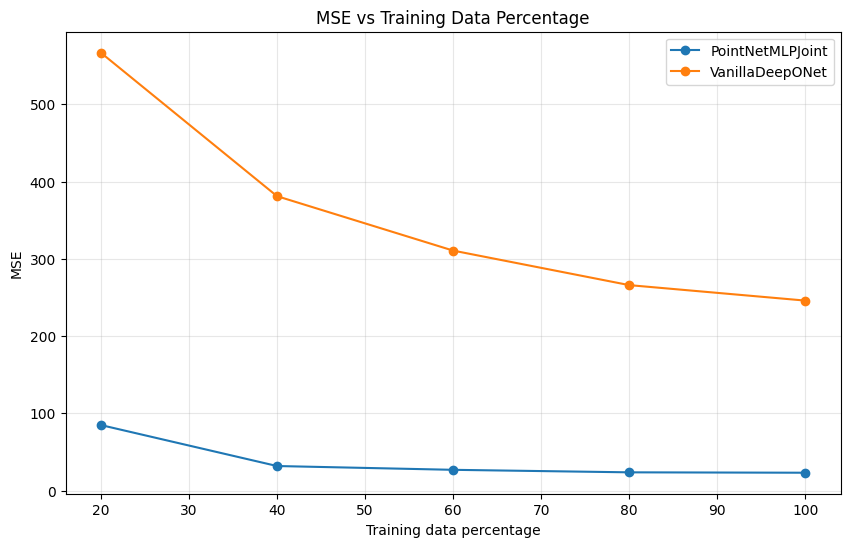

In [21]:
#plot MSE against percentage of training data for each model
plt.figure(figsize=(10, 6))
percentages = [20, 40, 60, 80, 100]

# Build model families safely by removing trailing digits (e.g., 20/40/60/80/100)
model_families = sorted({name.rstrip('0123456789') for name in model_dirs.keys()})

for family in model_families:
    mse_values = [L_bracket_results[f'{family}{p}']['MSE'] for p in percentages]
    plt.plot(percentages, mse_values, marker='o', label=family)

plt.xlabel('Training data percentage')
plt.ylabel('MSE')
plt.title('MSE vs Training Data Percentage')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

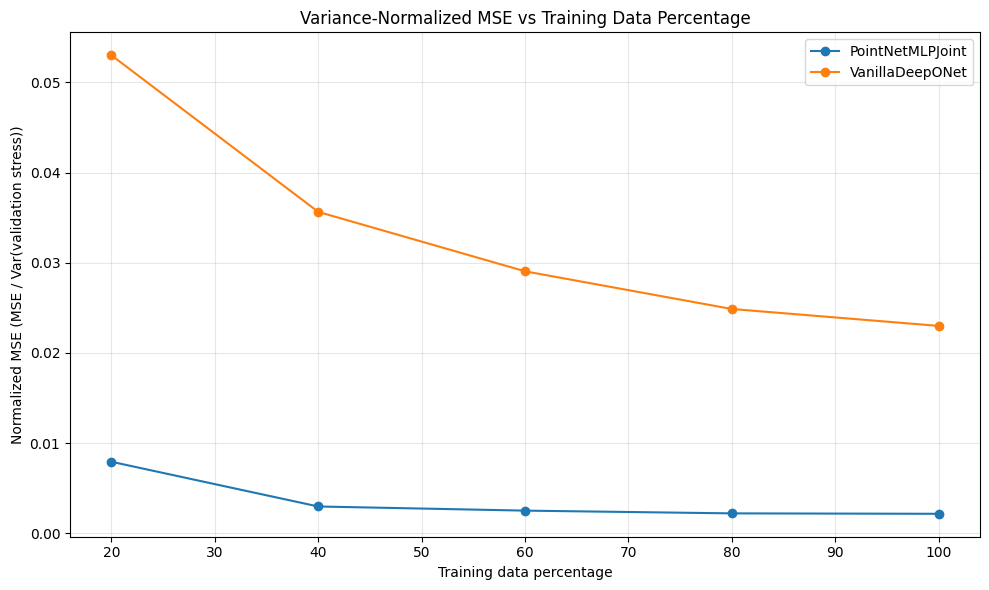

Validation stress variance used for normalization: 1.069292e+04


In [24]:
# Plot variance-normalized MSE (NMSE = MSE / Var(validation targets)) vs training data percentage
plt.figure(figsize=(10, 6))
percentages = [20, 40, 60, 80, 100]

# Build model families safely by removing trailing digits (e.g., 20/40/60/80/100)
model_families = sorted({name.rstrip('0123456789') for name in model_dirs.keys()})

# Gather validation targets and compute variance
val_targets = np.concatenate([sample[:, 2].cpu().numpy() for sample in L_bracket_val_samples])
val_variance = np.var(val_targets, ddof=0)

if np.isclose(val_variance, 0.0):
    raise ValueError('Validation target variance is zero; cannot compute variance-normalized MSE.')

for family in model_families:
    nmse_values = [L_bracket_results[f'{family}{p}']['MSE'] / val_variance for p in percentages]
    plt.plot(percentages, nmse_values, marker='o', label=family)

plt.xlabel('Training data percentage')
plt.ylabel('Normalized MSE (MSE / Var(validation stress))')
plt.title('Variance-Normalized MSE vs Training Data Percentage')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Validation stress variance used for normalization: {val_variance:.6e}')

Training history

In [7]:
train_history = {}
val_history = {}
for model_name, model_path in model_dirs.items():
    print(f'Evaluating {model_name}...')
    try:
        if 'PointNetMLPJoint' in model_name:
            model, norm_params, ckpt = load_model_and_checkpoint(model_path, 'PointNetMLPJoint')
        else:
            model, norm_params, ckpt = load_model_and_checkpoint(model_path, 'VanillaDeepONet')
        train_history[model_name] = ckpt.get('train_loss_history', [])
        val_history[model_name] = ckpt.get('val_loss_history', [])
    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")


Evaluating PointNetMLPJoint20...
Evaluating PointNetMLPJoint40...
Evaluating PointNetMLPJoint60...
Evaluating PointNetMLPJoint80...
Evaluating PointNetMLPJoint100...
Evaluating VanillaDeepONet20...
Evaluating VanillaDeepONet40...
Evaluating VanillaDeepONet60...
Evaluating VanillaDeepONet80...
Evaluating VanillaDeepONet100...


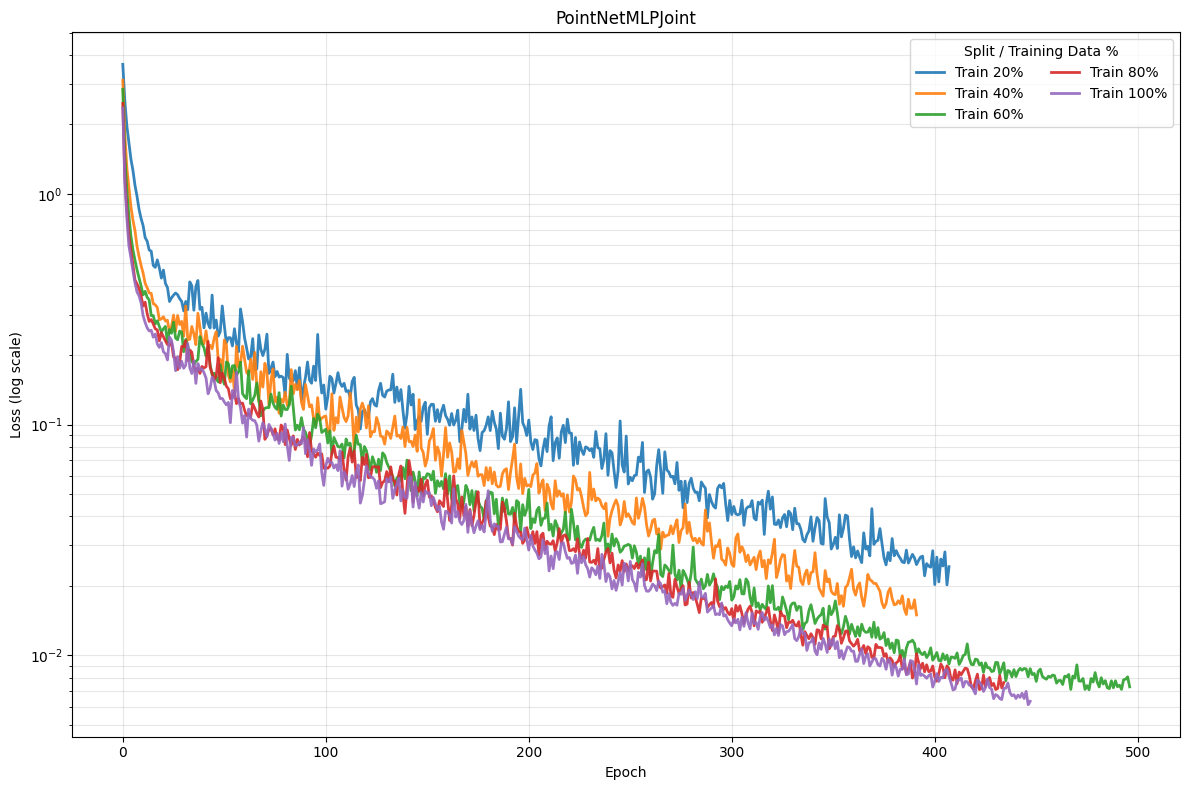

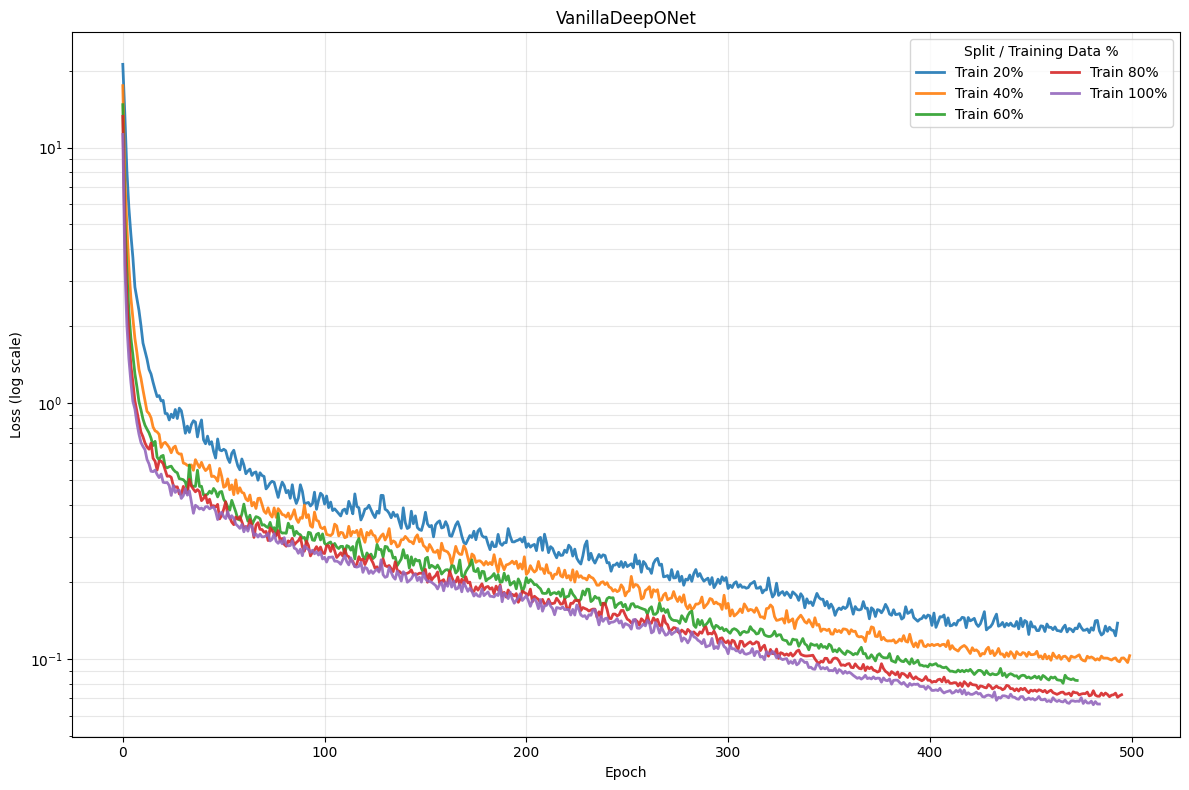

In [10]:
# Plot training/validation curves separately for each model family with log-scale loss
import re
plot_training_curves = True
plot_val_curves = False
# Group models by family and extract training percentage from model name
family_histories = {}
for model_name in sorted(train_history.keys()):
    match = re.search(r'(\d+)$', model_name)
    if not match:
        continue
    pct = int(match.group(1))
    family = model_name[:match.start()]
    family_histories.setdefault(family, []).append((pct, model_name))

for family, entries in family_histories.items():
    entries = sorted(entries, key=lambda x: x[0])  # sort by percentage
    
    plt.figure(figsize=(12, 8))
    for pct, model_name in entries:
        train_losses = train_history.get(model_name, [])
        val_losses = val_history.get(model_name, [])
        if plot_training_curves and len(train_losses) > 0:
            plt.plot(train_losses, linewidth=2, alpha=0.9, label=f'Train {pct}%')
        if plot_val_curves and len(val_losses) > 0:
            plt.plot(val_losses, linestyle='--', linewidth=2, alpha=0.9, label=f'Val {pct}%')

    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.title(family)
    plt.legend(title='Split / Training Data %', ncol=2)
    plt.grid(True, which='both', alpha=0.3)
    plt.tight_layout()
    plt.show()